In [1282]:
import numpy as np
import pandas as pd
from utils import *
import torch
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.stats import pearsonr

In [1283]:
np.random.seed(1)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1284]:
# Generate complete data
n = 100
p = 2

mu_X = np.repeat(1, p)
Sigma_X = np.array([[1, 1], [1, 4]])

X_complete_cont = np.random.multivariate_normal(mu_X, Sigma_X, size=n)

from scipy.stats import poisson

lamb = 0.5
X_complete_discr = poisson.rvs(lamb, size=n)
X_complete_discr = np.expand_dims(X_complete_discr, axis=1)

n_cat = 5
X_complete_cat = np.random.binomial(n=n_cat, p=0.5, size=n)
X_complete_cat = np.expand_dims(X_complete_cat, axis=1)

X_complete = np.concatenate((X_complete_cont, X_complete_discr, X_complete_cat), axis=1)

X_complete = pd.DataFrame(X_complete)

# Convert column 3 to categorical and set categories
X_complete[3] = X_complete[3].astype('category')
X_complete[3].cat.set_categories(["F", "E", "D", "C", "B", "A"])

X_complete.head()

,0,1,2,3
0,1.487501,4.372853,1.0,1.0
1,-0.174972,0.211042,1.0,1.0
2,-0.319125,3.275004,0.0,0.0
3,1.440477,4.648179,0.0,1.0
4,0.992486,1.693731,0.0,2.0


In [1285]:
def plot_mask_corr(mask, pattern_name):
    num_features = mask.shape[1]
    
    var_cols = np.std(mask, axis=0) > 0
    mask = mask[:, var_cols]
    original_indices = np.where(var_cols)[0]
    
    # --- Step 2: Check if there are enough features left to correlate ---
    
    num_features = mask.shape[1]
    p_value_matrix = np.zeros((num_features, num_features))
    for i in range(num_features):
        for j in range(i+1,num_features):
            feat1mask = mask[:, i]
            feat2mask = mask[:, j]        
            rho, p_value = pearsonr(feat1mask.astype(float), feat2mask.astype(float))
            p_value_matrix[i, j] = p_value
            p_value_matrix[j, i] = p_value
    plt.figure(figsize=(12, 10))
    mask_upper = np.triu(np.ones_like(p_value_matrix, dtype=bool), k=0)
    bonferroni_thresh = 0.05/(num_features*(num_features-1))
    cmap = ListedColormap(['#d84315', '#ffb74d','#e0e0e0'])  
    norm = BoundaryNorm([0, bonferroni_thresh, 0.05, 1], ncolors=cmap.N)
    sns.heatmap(p_value_matrix, 
                mask=mask_upper, 
                annot=True, 
                fmt=".2e", 
                cmap=cmap,
                norm=norm,
                linewidths=.5,
               cbar_kws={'format': '%.4f'},
               xticklabels=original_indices,
                yticklabels=original_indices)
    
    plt.title('Lower Triangular Heatmap of P-values for {} Mask Correlation'.format(pattern_name), fontsize=16)
    plt.xlabel('Feature Index', fontsize=12)
    plt.ylabel('Feature Index', fontsize=12)
    plt.show()

In [1286]:
def plot_mask_corr_rho(mask, pattern_name):
    num_features = mask.shape[1]
    
    var_cols = np.std(mask, axis=0) > 0
    mask = mask[:, var_cols]
    original_indices = np.where(var_cols)[0]
    
    # --- Step 2: Check if there are enough features left to correlate ---
    
    num_features = mask.shape[1]
    p_value_matrix = np.zeros((num_features, num_features))
    for i in range(num_features):
        for j in range(i+1,num_features):
            feat1mask = mask[:, i]
            feat2mask = mask[:, j]        
            rho, p_value = pearsonr(feat1mask.astype(float), feat2mask.astype(float))
            p_value_matrix[i, j] = rho
            p_value_matrix[j, i] = rho
    plt.figure(figsize=(12, 10))
    mask_upper = np.triu(np.ones_like(p_value_matrix, dtype=bool), k=0)
    bonferroni_thresh = 0.05/(num_features*(num_features-1))
    cmap = ListedColormap(['#d84315', '#ffb74d','#e0e0e0'])  
    norm = BoundaryNorm([0, bonferroni_thresh, 0.05, 1], ncolors=cmap.N)
    sns.heatmap(p_value_matrix, 
                mask=mask_upper, 
                annot=True, 
                fmt=".2e", 
                cmap=cmap,
                norm=norm,
                linewidths=.5,
               cbar_kws={'format': '%.4f'},
               xticklabels=original_indices,
                yticklabels=original_indices)
    
    plt.title('Lower Triangular Heatmap of P-values for {} Mask Correlation'.format(pattern_name), fontsize=16)
    plt.xlabel('Feature Index', fontsize=12)
    plt.ylabel('Feature Index', fontsize=12)
    plt.show()

In [1287]:
# # from simulate import simulate_nan

# for i in range(1):
#     X_miss_mcar = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MCAR", structured=True, weak=False, sequential=True)
#     X_mcar = X_miss_mcar['X_incomp']
#     R_mcar = X_miss_mcar['mask']

# print("Percentage of newly generated missing values: ", (R_mcar.sum())/np.prod(R_mcar.shape)*100, " %")
# ax = sns.heatmap(X_mcar, mask=R_mcar==1, linewidths=0.005, linecolor='black')

In [1288]:
num_tests = range(1)
X_complete_cont = np.random.rand(10000, 10)
# X_complete_cont = np.random.rand(100, 10)

In [1289]:
from simulate import simulate_nan

In [1290]:
X_miss_mcar = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MCAR")
X_mcar = X_miss_mcar['X_incomp']
R_mcar = X_miss_mcar['mask']
#R_mcar

# MCAR

### MCAR Unstructured (I)

Percentage of newly generated missing values:  40.082  %


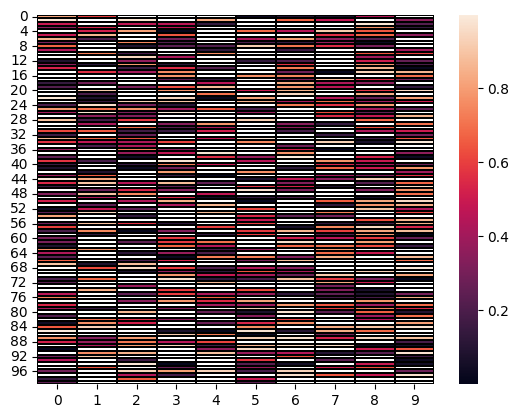

In [1291]:
for i in num_tests:
    X_miss_mcar_U = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MCAR")

    X_mcar_U = X_miss_mcar_U['X_incomp']
    R_mcar_U = X_miss_mcar_U['mask']

print("Percentage of newly generated missing values: ", (R_mcar_U.sum())/np.prod(R_mcar_U.shape)*100, " %")
ax = sns.heatmap(X_mcar_U[:100], mask=R_mcar_U[:100]==1, linewidths=0.005, linecolor='black')

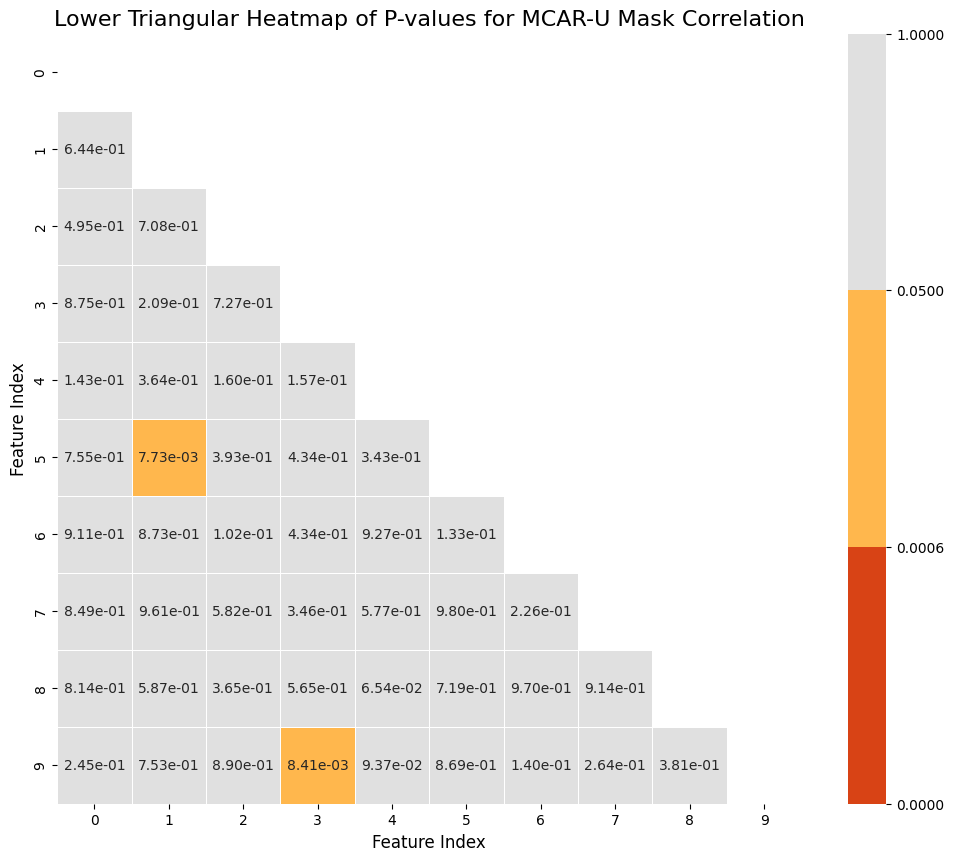

In [1292]:
plot_mask_corr(R_mcar_U, "MCAR-U")

### MCAR Structured

#### MCAR WS-Block (II)

Percentage of newly generated missing values:  40.142  %


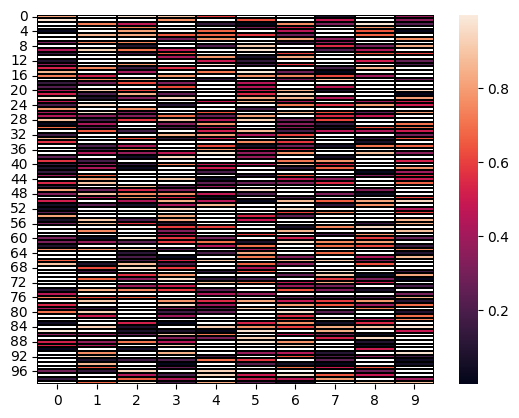

In [1293]:
for i in num_tests:
    X_miss_mcar_WSB = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MCAR", structured=True, weak=True, sequential=False)

    X_mcar_WSB = X_miss_mcar_WSB['X_incomp']
    R_mcar_WSB = X_miss_mcar_WSB['mask']

print("Percentage of newly generated missing values: ", (R_mcar_WSB.sum())/np.prod(R_mcar_WSB.shape)*100, " %")
ax = sns.heatmap(X_mcar_WSB[:100], mask=R_mcar_WSB[:100]==1, linewidths=0.005, linecolor='black')

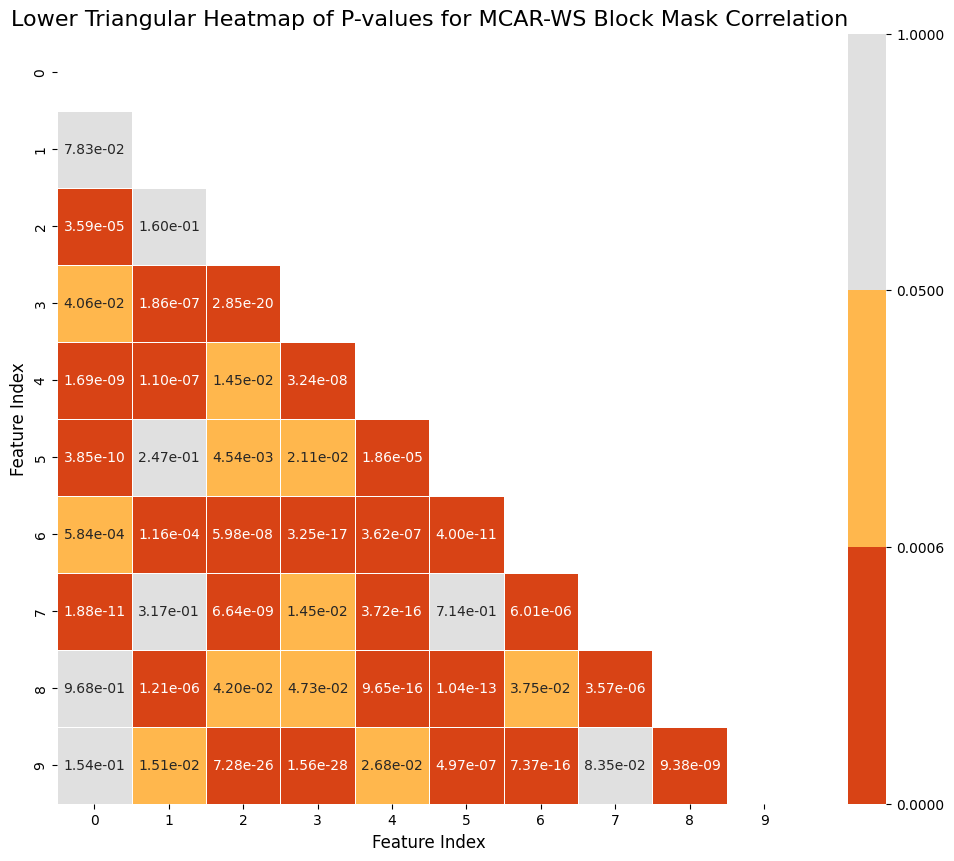

In [1294]:
plot_mask_corr(R_mcar_WSB, "MCAR-WS Block")

#### MCAR SS-Block (III)

Percentage of newly generated missing values:  40.0  %


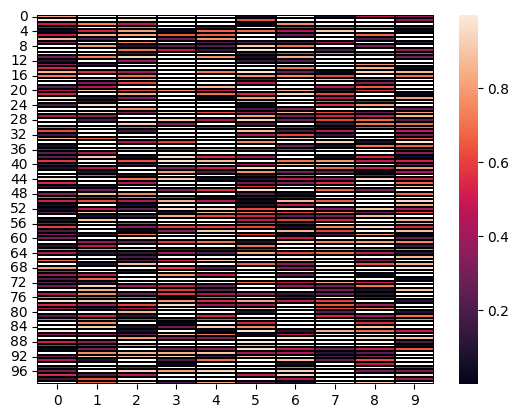

In [1295]:
for i in num_tests:
    X_miss_mcar_SSB = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MCAR", structured=True, weak=False, sequential=False)
    
    X_mcar_SSB = X_miss_mcar_SSB['X_incomp']
    R_mcar_SSB = X_miss_mcar_SSB['mask']

print("Percentage of newly generated missing values: ", (R_mcar_SSB.sum())/np.prod(R_mcar_SSB.shape)*100, " %")
ax = sns.heatmap(X_mcar_SSB[:100], mask=R_mcar_SSB[:100]==1, linewidths=0.005, linecolor='black')

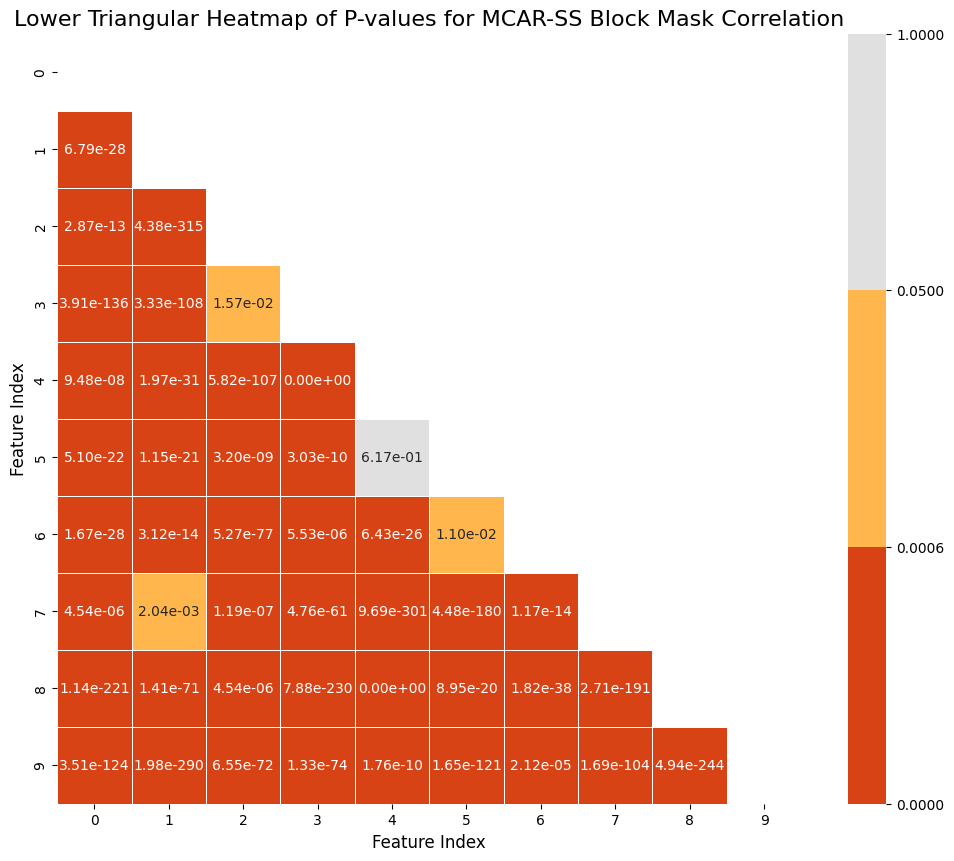

In [1296]:
plot_mask_corr(R_mcar_SSB, "MCAR-SS Block")

#### MCAR WS-Sequential (IV)

Percentage of newly generated missing values:  39.931  %


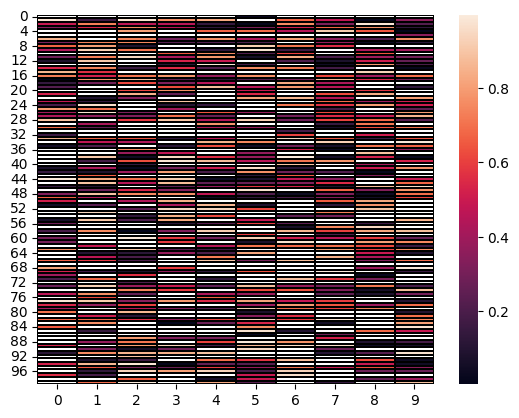

In [1297]:
for i in num_tests:
    X_miss_mcar_WSS = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MCAR", structured=True, weak=True, sequential=True)

    X_mcar_WSS = X_miss_mcar_WSS['X_incomp']
    R_mcar_WSS = X_miss_mcar_WSS['mask']

print("Percentage of newly generated missing values: ", (R_mcar_WSS.sum())/np.prod(R_mcar_WSS.shape)*100, " %")
ax = sns.heatmap(X_mcar_WSS[:100], mask=R_mcar_WSS[:100]==1, linewidths=0.005, linecolor='black')

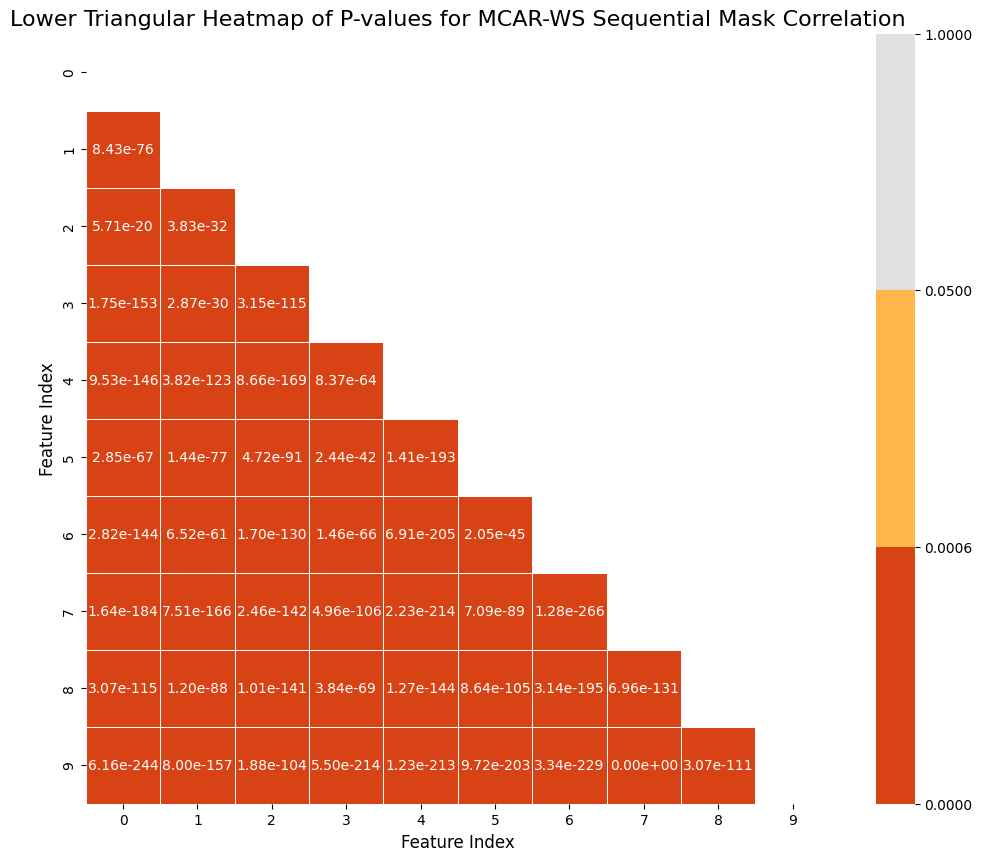

In [1298]:
plot_mask_corr(R_mcar_WSS, "MCAR-WS Sequential")

#### MCAR SS-Sequential (V)

Percentage of newly generated missing values:  40.17  %


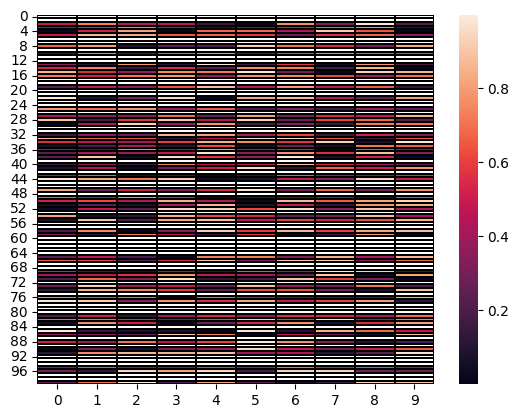

In [1299]:
j = 0
for i in num_tests:
    X_miss_mcar_SSS = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MCAR", structured=True, weak=False, sequential=True)

    X_mcar_SSS = X_miss_mcar_SSS['X_incomp']
    R_mcar_SSS = X_miss_mcar_SSS['mask']

#print(j/len(num_tests))
print("Percentage of newly generated missing values: ", (R_mcar_SSS.sum())/np.prod(R_mcar_SSS.shape)*100, " %")
ax = sns.heatmap(X_mcar_SSS[:100], mask=R_mcar_SSS[:100]==1, linewidths=0.005, linecolor='black')

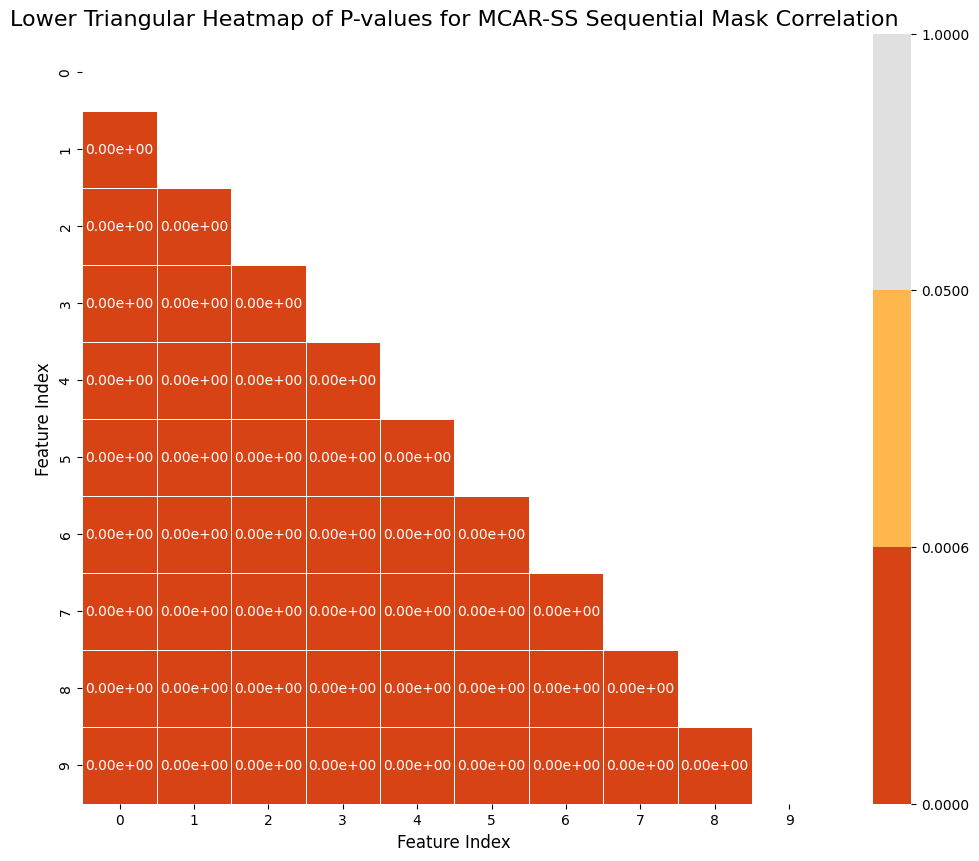

In [1300]:
plot_mask_corr(R_mcar_SSS, "MCAR-SS Sequential")

# MAR

### MAR Unstructured

#### MAR Unstructured-Prob. (VI)

Percentage of generated missing values:  19.997  %


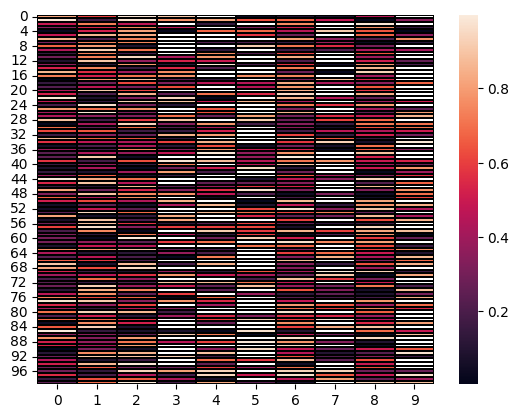

In [1301]:
for i in num_tests:
    X_miss_mar_UP = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MAR", p_obs=0.5)

    X_mar_UP = X_miss_mar_UP['X_incomp']
    R_mar_UP = X_miss_mar_UP['mask']

print("Percentage of generated missing values: ", (R_mar_UP.sum())/np.prod(R_mar_UP.shape)*100, " %")

ax = sns.heatmap(X_mar_UP[:100], mask=R_mar_UP[:100]==1, linewidths=0.005, linecolor='black')

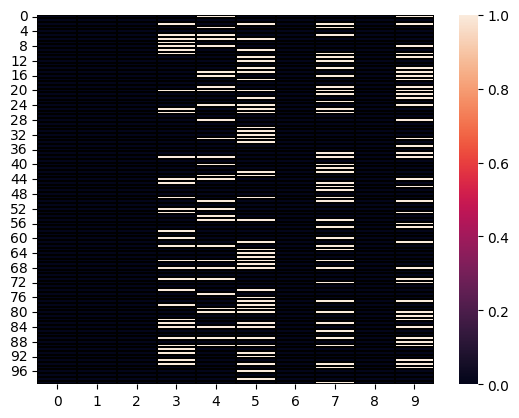

In [1302]:
ax = sns.heatmap(R_mar_UP[:100], linewidths=0.005, linecolor='black')

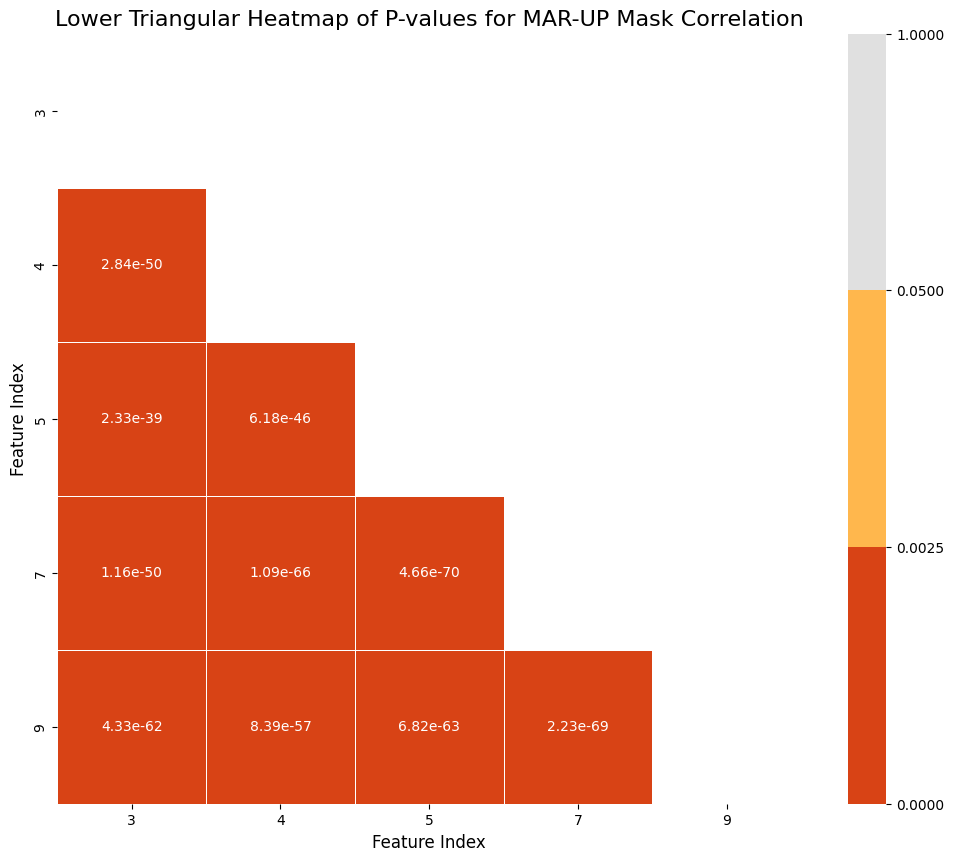

In [1303]:
plot_mask_corr(R_mar_UP, "MAR-UP")

#### MAR Unstructured-Det. (VII)

Percentage of generated missing values:  20.0  %


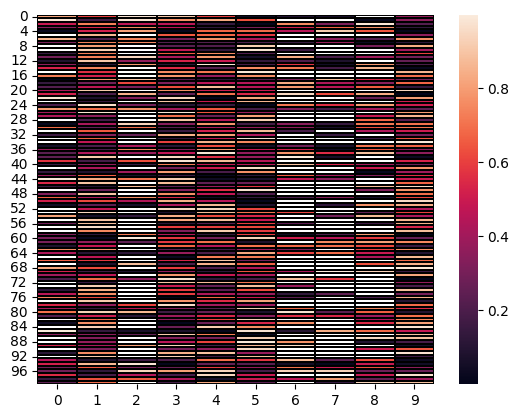

In [1304]:
for i in num_tests:
    X_miss_mar_UD = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MAR", weak=False, p_obs=0.5)

    X_mar_UD = X_miss_mar_UD['X_incomp']
    R_mar_UD = X_miss_mar_UD['mask']

print("Percentage of generated missing values: ", (R_mar_UD.sum())/np.prod(R_mar_UD.shape)*100, " %")

ax = sns.heatmap(X_mar_UD[:100], mask=R_mar_UD[:100]==1, linewidths=0.005, linecolor='black')

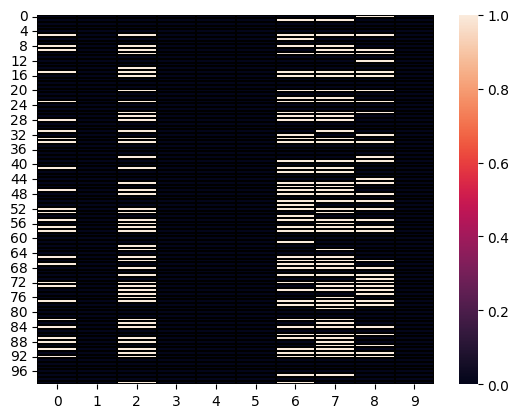

In [1327]:
ax = sns.heatmap(R_mar_UD[:100]==1, linewidths=0.005, linecolor='black')

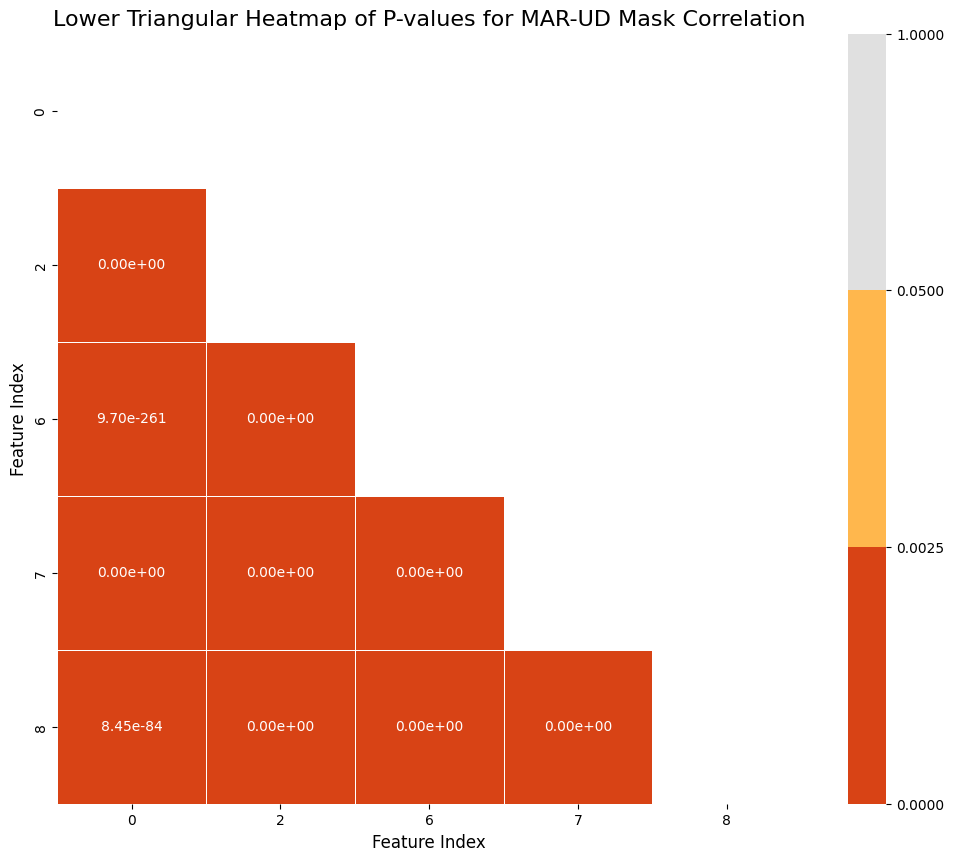

In [1305]:
plot_mask_corr(R_mar_UD, "MAR-UD")

### MAR Structured

#### MAR WS-Block (VIII)

Percentage of generated missing values:  19.997  %


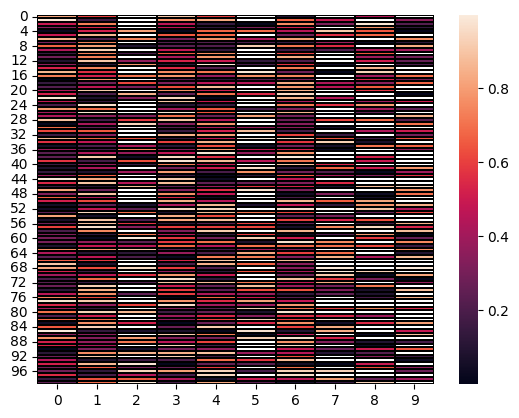

In [1328]:
for i in num_tests:
    X_miss_mar_WSB = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MAR", p_obs=0.5, structured=True, weak=True, sequential=False)

    X_mar_WSB = X_miss_mar_WSB['X_incomp']
    R_mar_WSB = X_miss_mar_WSB['mask']

print("Percentage of generated missing values: ", (R_mar_WSB.sum())/np.prod(R_mar_WSB.shape)*100, " %")

ax = sns.heatmap(X_mar_WSB[:100], mask=R_mar_WSB[:100]==1, linewidths=0.005, linecolor='black')

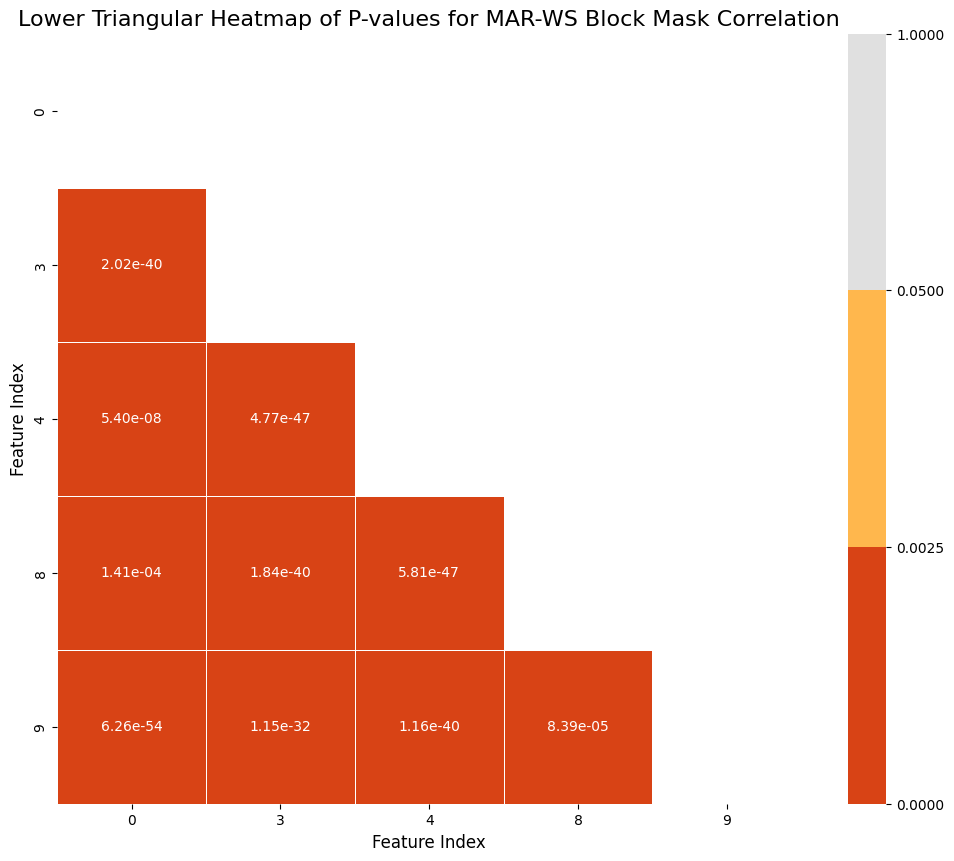

In [1307]:
plot_mask_corr(R_mar_WSB, "MAR-WS Block")

#### MAR SS-Block (IX)

Percentage of generated missing values:  20.0  %


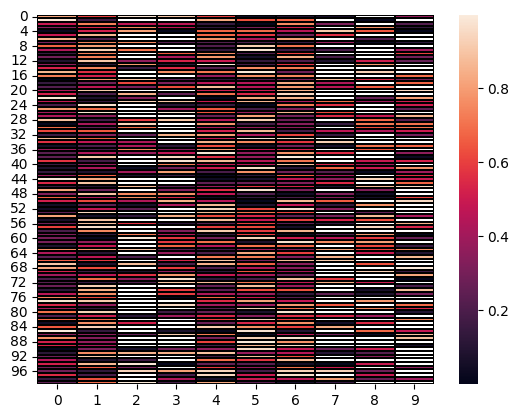

In [1308]:
for i in num_tests:
    X_miss_mar_SSB = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MAR", p_obs=0.5, structured=True, weak=False, sequential=False)

    X_mar_SSB = X_miss_mar_SSB['X_incomp']
    R_mar_SSB = X_miss_mar_SSB['mask']

print("Percentage of generated missing values: ", (R_mar_SSB.sum())/np.prod(R_mar_SSB.shape)*100, " %")

ax = sns.heatmap(X_mar_SSB[:100], mask=R_mar_SSB[:100]==1, linewidths=0.005, linecolor='black')

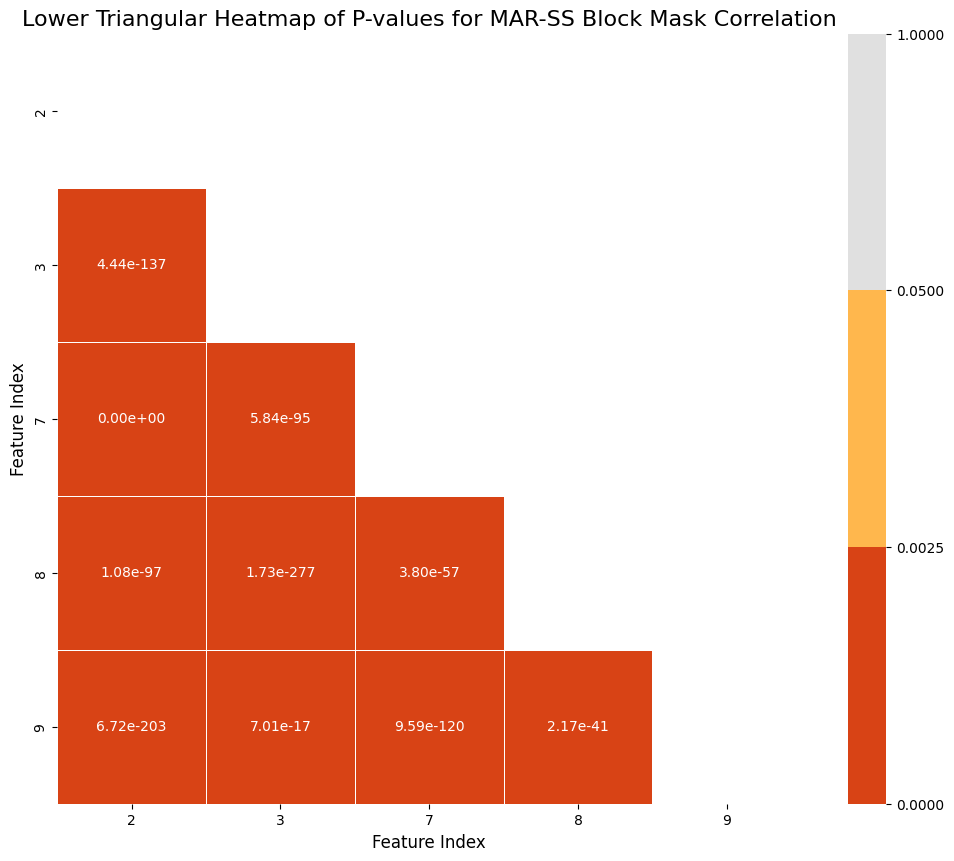

In [1309]:
plot_mask_corr(R_mar_SSB, "MAR-SS Block")

#### MAR WS-Sequential (X)

Percentage of generated missing values:  20.119  %


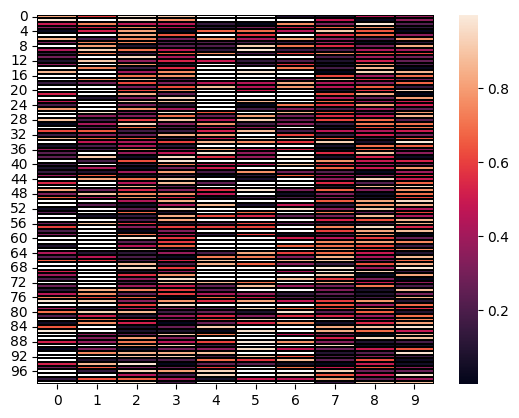

In [1310]:
import warnings
warnings.filterwarnings('ignore')

for i in num_tests:
    X_miss_mar_WSS = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MAR", p_obs=0.5, structured=True, weak=True, sequential=True)

    X_mar_WSS = X_miss_mar_WSS['X_incomp']
    R_mar_WSS = X_miss_mar_WSS['mask']

print("Percentage of generated missing values: ", (R_mar_WSS.sum())/np.prod(R_mar_WSS.shape)*100, " %")

ax = sns.heatmap(X_mar_WSS[:100], mask=R_mar_WSS[:100]==1, linewidths=0.005, linecolor='black')

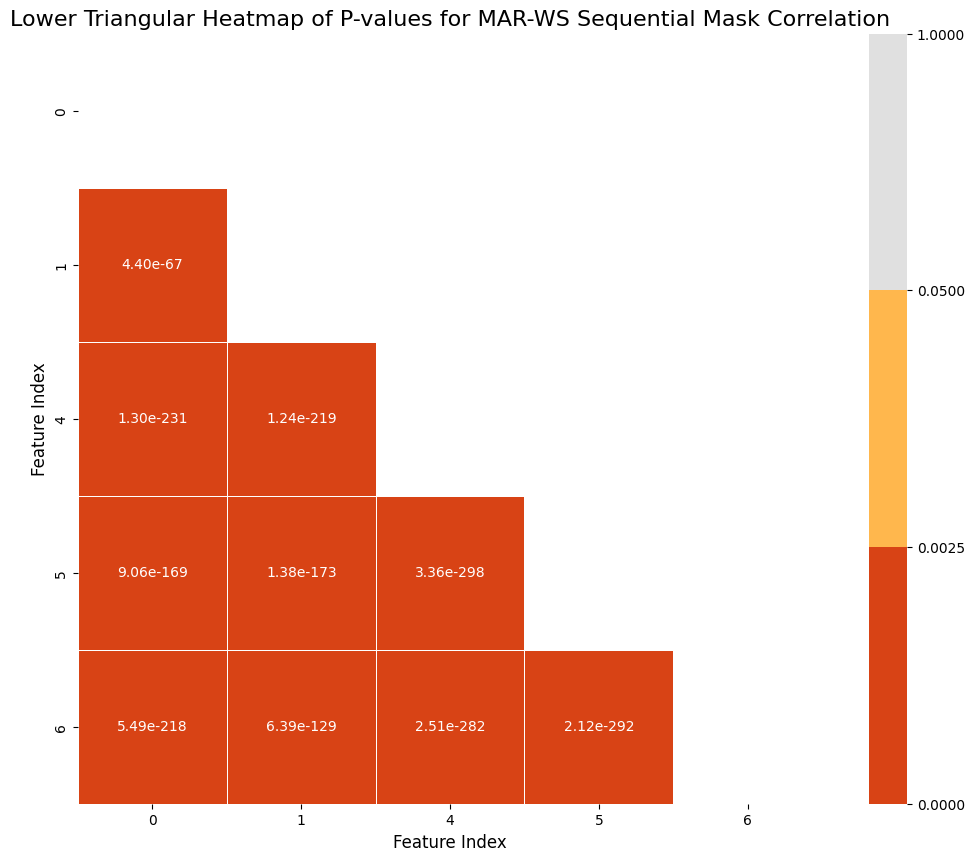

In [1311]:
plot_mask_corr(R_mar_WSS, "MAR-WS Sequential")

#### MAR SS-Sequential (XI)

Percentage of generated missing values:  20.0  %


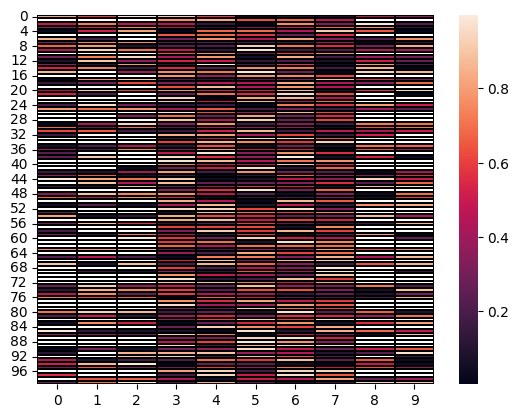

In [1329]:
for i in num_tests:
    X_miss_mar_SSS = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MAR", p_obs=0.5, structured=True, weak=False, sequential=True)

    X_mar_SSS = X_miss_mar_SSS['X_incomp']
    R_mar_SSS = X_miss_mar_SSS['mask']

print("Percentage of generated missing values: ", (R_mar_SSS.sum())/np.prod(R_mar_SSS.shape)*100, " %")

ax = sns.heatmap(X_mar_SSS[:100], mask=R_mar_SSS[:100]==1, linewidths=0.005, linecolor='black')

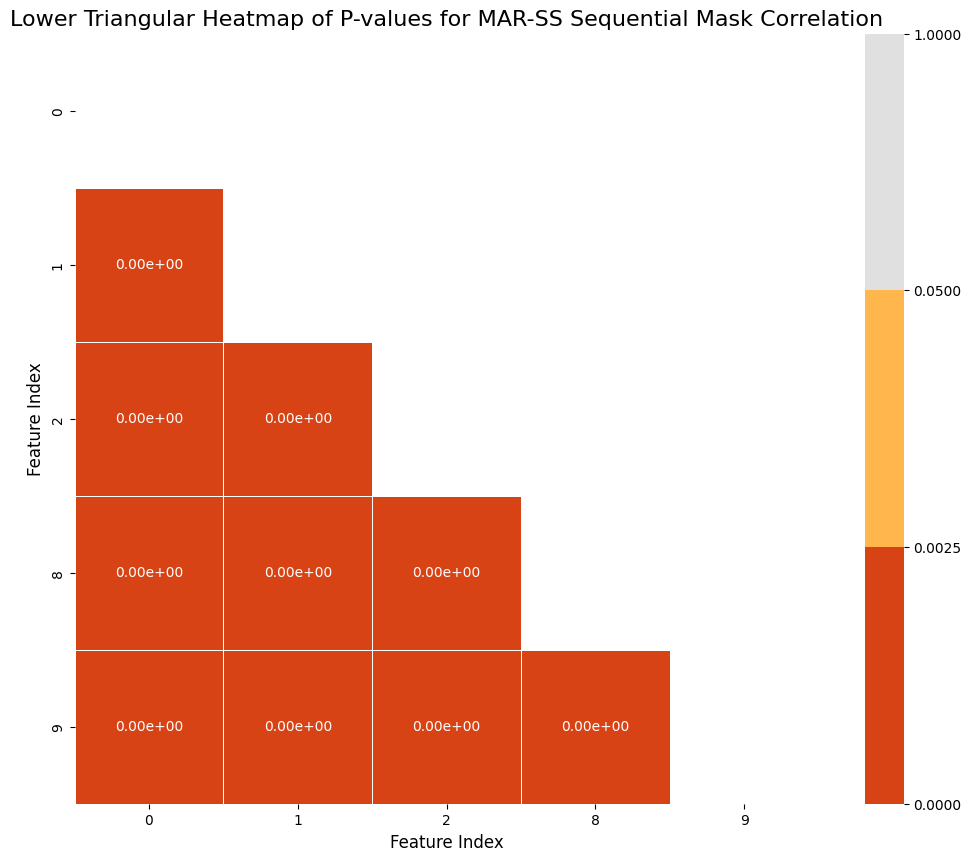

In [1331]:
plot_mask_corr(R_mar_SSS, "MAR-SS Sequential")

# MNAR

### MNAR Unstructured

#### MNAR Unstructured-Prob. (XII)

Percentage of generated missing values:  40.144999999999996  %


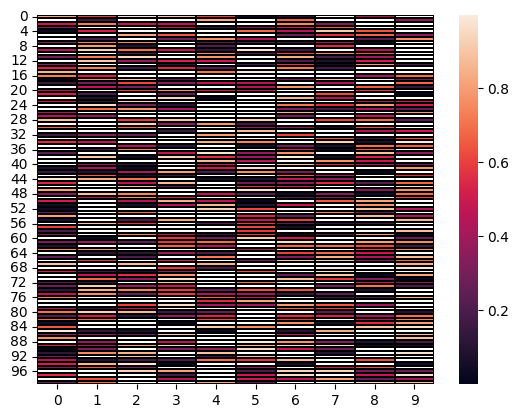

In [1314]:
for i in num_tests:
    X_miss_mnar_UP = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MNAR", p_obs=0.5, structured=False, weak=True, sequential=True)

    X_mnar_UP = X_miss_mnar_UP['X_incomp']
    R_mnar_UP = X_miss_mnar_UP['mask']

print("Percentage of generated missing values: ", (R_mnar_UP.sum())/np.prod(R_mnar_UP.shape)*100, " %")

ax = sns.heatmap(X_mnar_UP[:100], mask=R_mnar_UP[:100]==1, linewidths=0.005, linecolor='black')

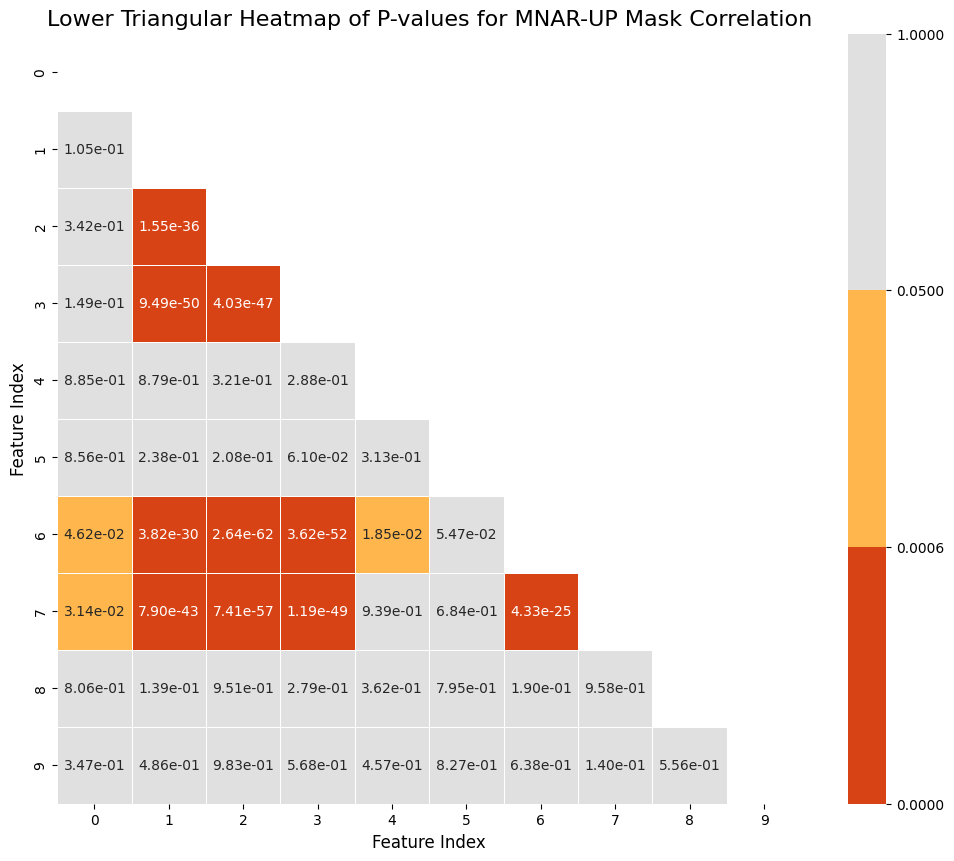

In [1315]:
plot_mask_corr(R_mnar_UP, "MNAR-UP")

#### MNAR Unstructured-Det. (XIII)

Percentage of generated missing values:  40.088  %


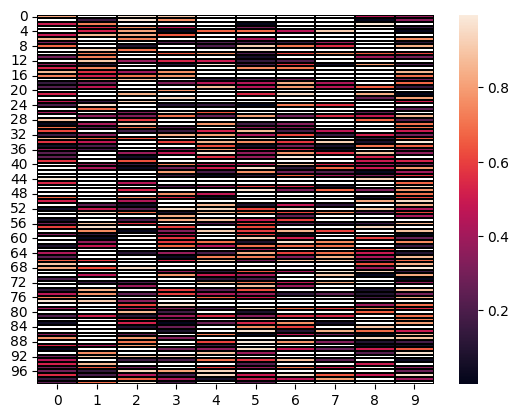

In [1316]:
for i in num_tests:
    X_miss_mnar_UD = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MNAR", p_obs=0.5, structured=False, weak=False, sequential=True)

    X_mnar_UD = X_miss_mnar_UD['X_incomp']
    R_mnar_UD = X_miss_mnar_UD['mask']

print("Percentage of generated missing values: ", (R_mnar_UD.sum())/np.prod(R_mnar_UD.shape)*100, " %")

ax = sns.heatmap(X_mnar_UD[:100], mask=R_mnar_UD[:100]==1, linewidths=0.005, linecolor='black')

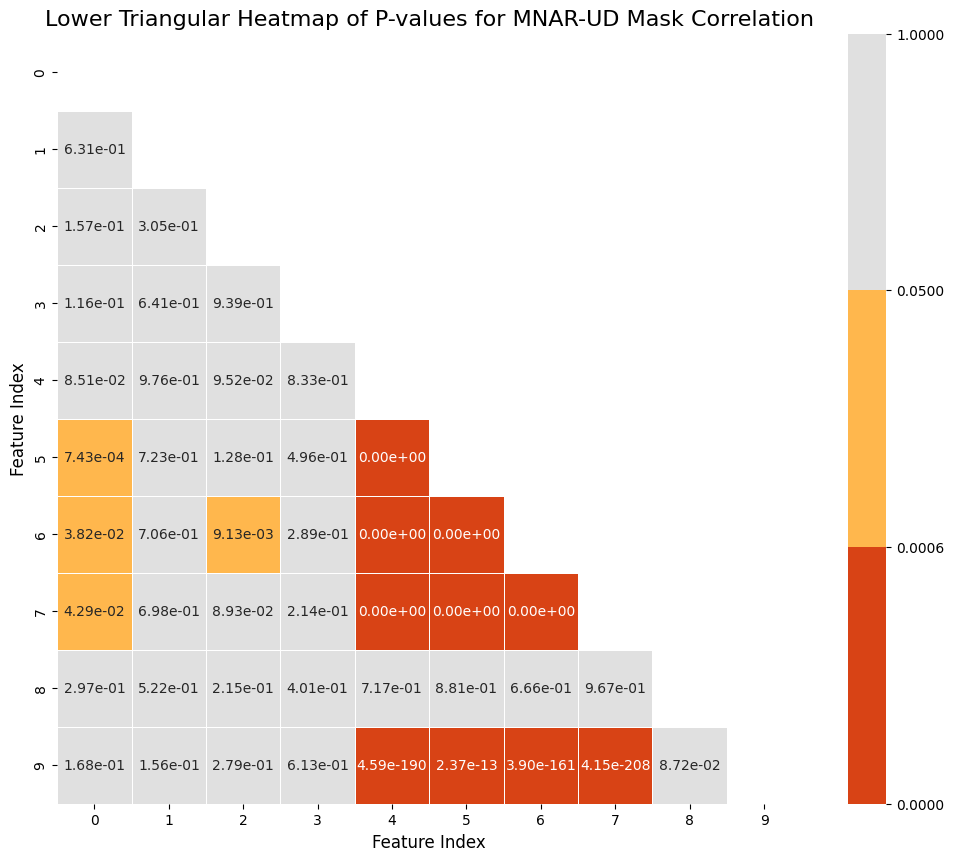

In [1317]:
plot_mask_corr(R_mnar_UD, "MNAR-UD")

### MNAR Structured

#### MNAR WS-Block (XIV)

Percentage of generated missing values:  40.39  %


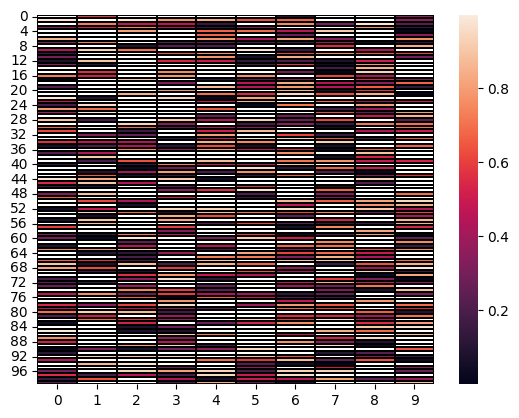

In [1318]:
for i in num_tests:
    X_miss_mnar_WSB = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MNAR", p_obs=0.5, structured=True, weak=True, sequential=False)

    X_mnar_WSB = X_miss_mnar_WSB['X_incomp']
    R_mnar_WSB = X_miss_mnar_WSB['mask']

print("Percentage of generated missing values: ", (R_mnar_WSB.sum())/np.prod(R_mnar_WSB.shape)*100, " %")

ax = sns.heatmap(X_mnar_WSB[:100], mask=R_mnar_WSB[:100]==1, linewidths=0.005, linecolor='black')

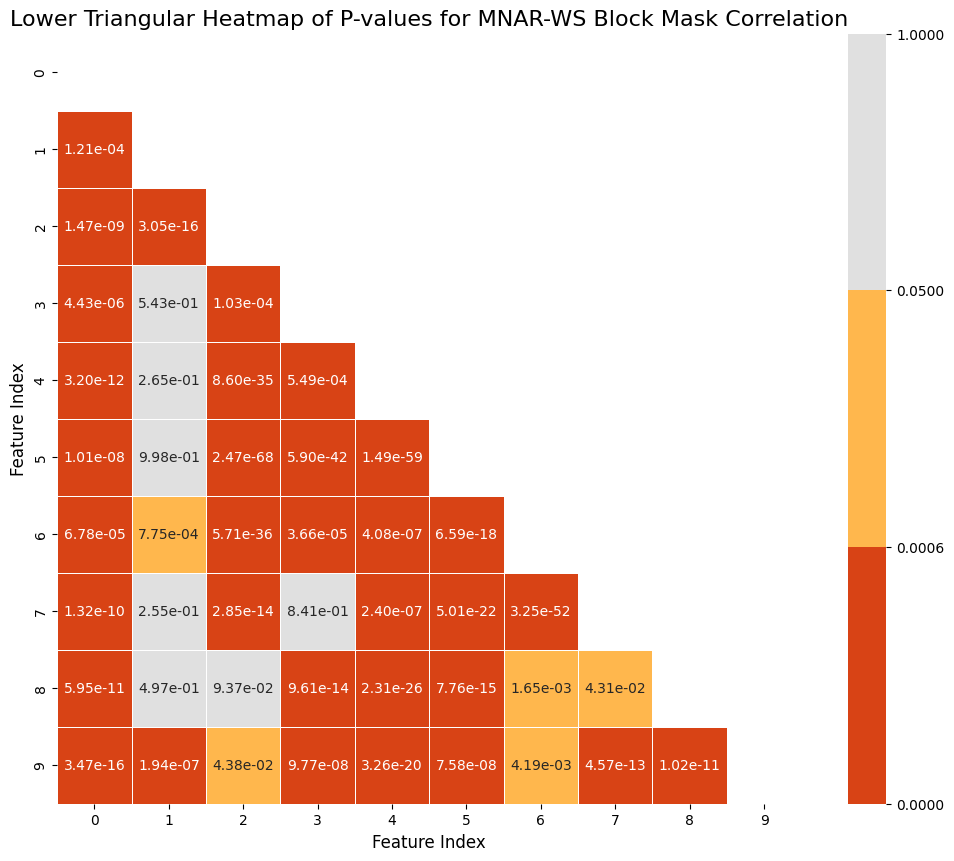

In [1319]:
plot_mask_corr(R_mnar_WSB, "MNAR-WS Block")

#### MNAR SS-Block (XV)

Percentage of generated missing values:  40.0  %


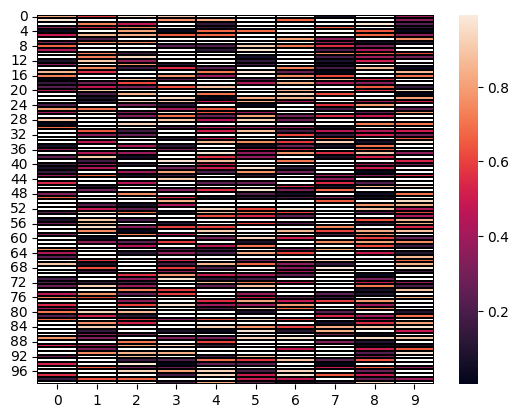

In [1320]:
for i in num_tests:
    X_miss_mnar_SSB = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MNAR", p_obs=0.5, structured=True, weak=False, sequential=False,coeff_dist="normal")

    X_mnar_SSB = X_miss_mnar_SSB['X_incomp']
    R_mnar_SSB = X_miss_mnar_SSB['mask']

print("Percentage of generated missing values: ", (R_mnar_SSB.sum())/np.prod(R_mnar_SSB.shape)*100, " %")

ax = sns.heatmap(X_mnar_SSB[:100], mask=R_mnar_SSB[:100]==1, linewidths=0.005, linecolor='black')

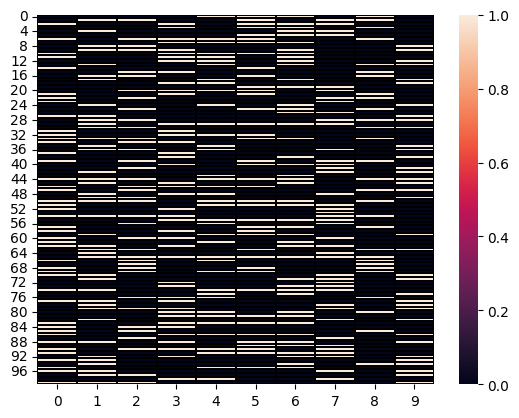

In [1321]:
ax = sns.heatmap(R_mnar_SSB[:100]==1, linewidths=0.005, linecolor='black')

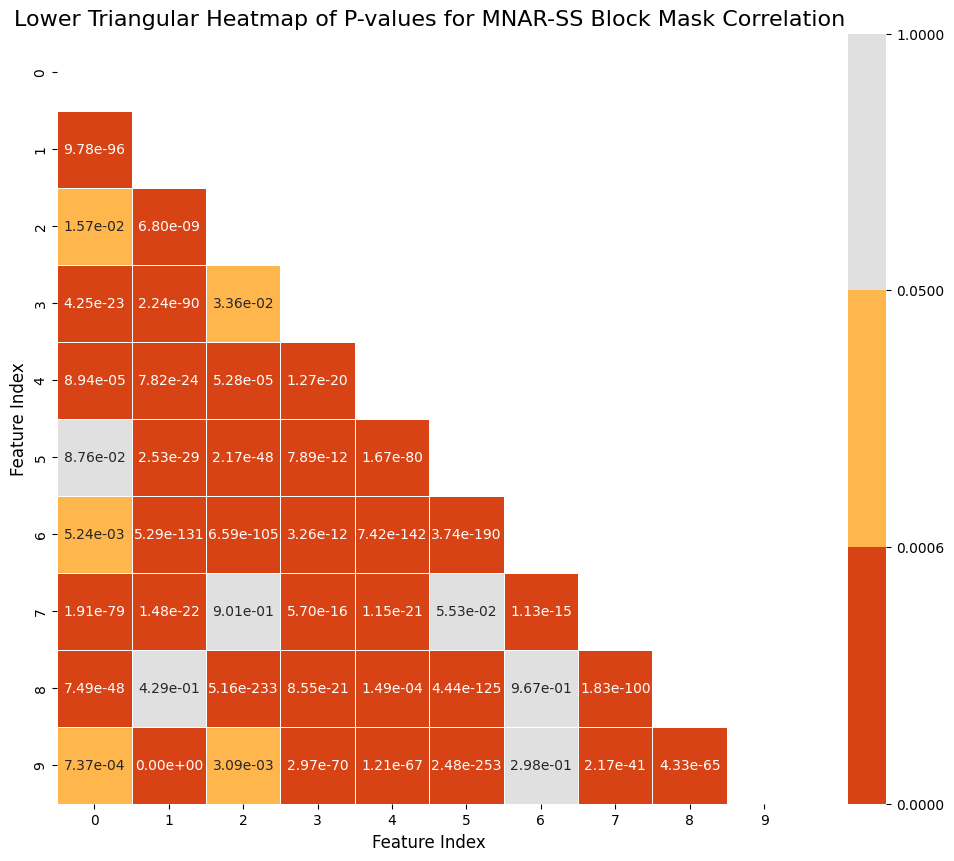

In [1322]:
plot_mask_corr(R_mnar_SSB, "MNAR-SS Block")

#### MNAR WS-Sequential (XVI)

Percentage of generated missing values:  39.77  %


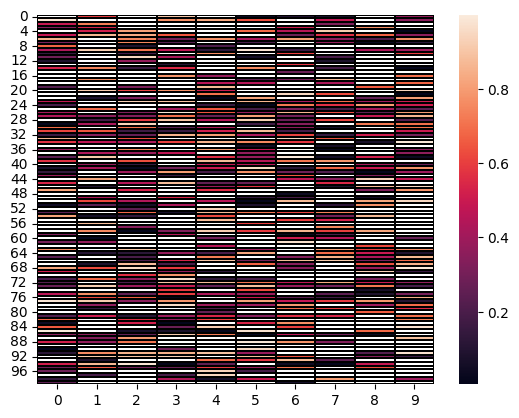

In [1323]:
for i in num_tests:
    X_miss_mnar_WSS = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MNAR", p_obs=0.5, structured=True, weak=True, sequential=True)

    X_mnar_WSS = X_miss_mnar_WSS['X_incomp']
    R_mnar_WSS = X_miss_mnar_WSS['mask']

print("Percentage of generated missing values: ", (R_mnar_WSS.sum())/np.prod(R_mnar_WSS.shape)*100, " %")

ax = sns.heatmap(X_mnar_WSS[:100], mask=R_mnar_WSS[:100]==1, linewidths=0.005, linecolor='black')

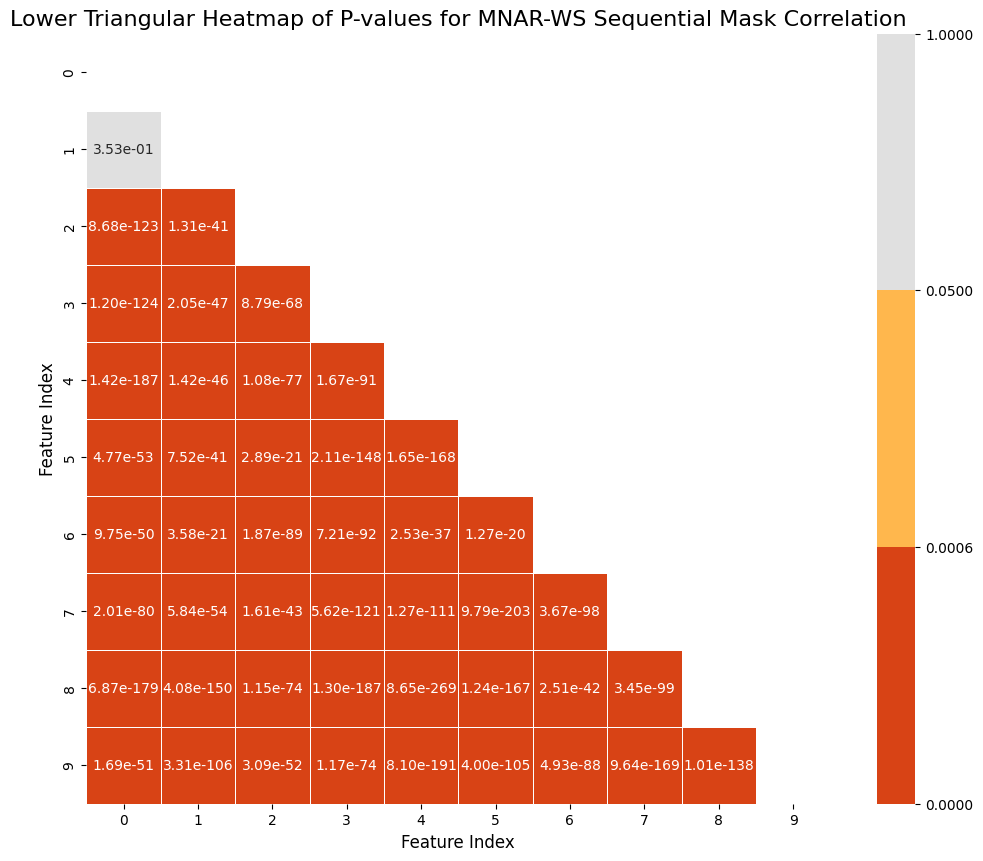

In [1324]:
plot_mask_corr(R_mnar_WSS, "MNAR-WS Sequential")

#### MNAR SS-Sequential (XVII)

Percentage of generated missing values:  40.0  %


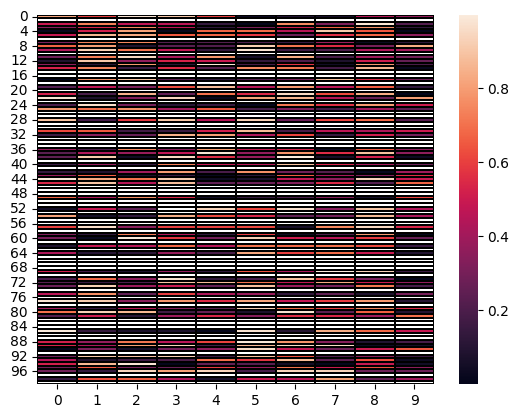

In [1325]:
for i in num_tests:
    X_miss_mnar_SSS = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MNAR", p_obs=0.5, structured=True, weak=False, sequential=True)

    X_mnar_SSS = X_miss_mnar_SSS['X_incomp']
    R_mnar_SSS = X_miss_mnar_SSS['mask']

print("Percentage of generated missing values: ", (R_mnar_SSS.sum())/np.prod(R_mnar_SSS.shape)*100, " %")

ax = sns.heatmap(X_mnar_SSS[:100], mask=R_mnar_SSS[:100]==1, linewidths=0.005, linecolor='black')

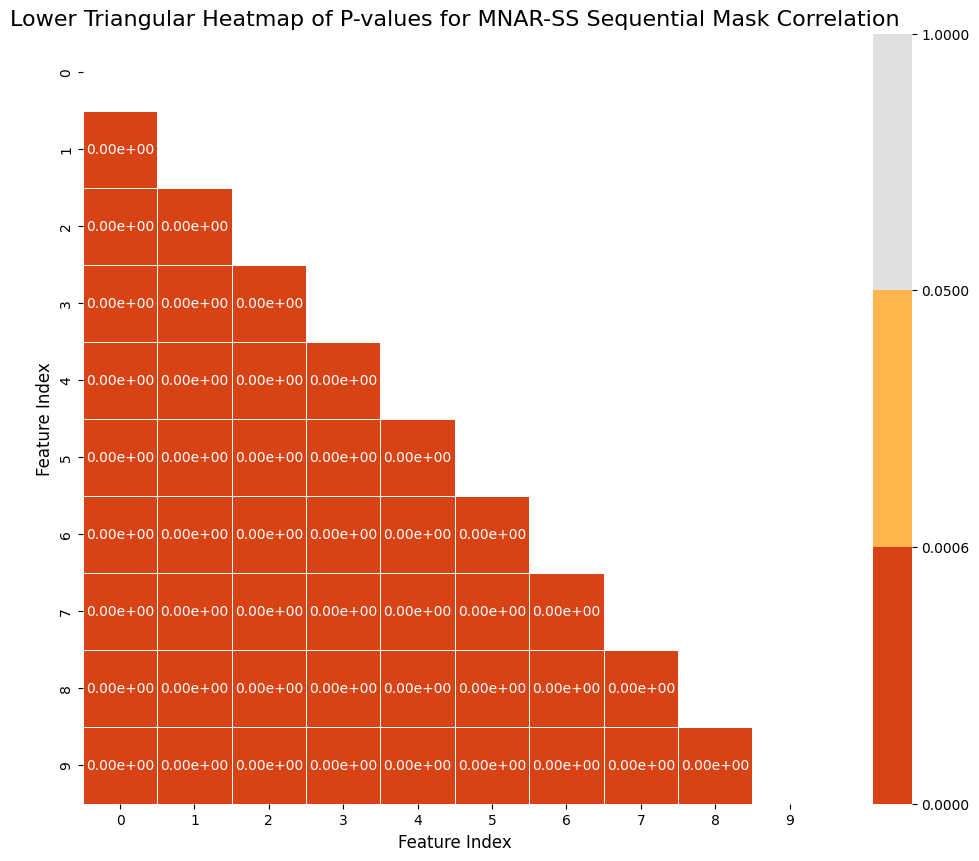

In [1326]:
plot_mask_corr(R_mnar_SSS, "MNAR-SS Sequential")